# Extraction d'informations
L'entrée est le fichier JSON `diderot_1751_wd` contenant les QID. Pour tout QID, le programme extrait les types wikidata, les libellés, titres et positions géographiques si ces informations existent. On fusionne les informations pour chaque QID.

On extrait les coordonnées car on suppose que la majorité des références seront des lieux. On extrait aussi les dates de naissance et de décès quand elles existent.

__auteur__: Pierre Nugues

In [1]:
import regex as re
import bs4
import requests
import sys
import os
import pickle
from tqdm import tqdm
import pandas as pd
from collections import OrderedDict
import time
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
from collections import Counter
import json

In [2]:
RTO = 1  # Temps d'attente avant retransmission de la requête. Voir protocole TCP
MAX_ESSAIS = 5

In [3]:
with open('../diderot_1751_wd.json', 'r') as f:
    diderot_wd = json.loads(f.read())

In [4]:
# url = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql'
url = 'https://query.wikidata.org/sparql'

In [5]:
prefixes = '''PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>'''

In [6]:
headers = {
    'User-Agent': 'encyclobot/1.0 (pierre.nugues@cs.lth.se)'
}

## Structure les articles. Quelques exemples

In [7]:
diderot_wd[4909]

{'vedette': 'GRENOBLE',
 'entreeid': 'v7-1475-0',
 'texte': 'GRENOBLE, Gratianopolis, (Géogr.)\u200b ancienne ville de France, capitale du Dauphiné, avec un évêché suffragant de Vienne, & un parlement érigé en 1493 par Louis XI. qui n’étoit encore que dauphin ; mais son pere ratifia cette érection deux ans après.\n\n\nGrenoble est sur l’Isere, à onze lieues S O. de Chambéri, quarante-deux N. O. de Turin, seize S. E. de Vienne, cent vingt-quatre S. O. de Paris. Long. suivant Harris, 23d. 31′. 15″. suivant Cassini, 23d. 14′. 15″. latit 45d. 11′.\n\n\nCette ville reçut le nom de Gratianopolis de l’empereur Gratien fils de Valentinien I. car elle s’appelloit auparavant Cularo ; & c’est sous ce nom qu’il en est parlé dans une lettre de Plancus à Cicéron, epist. xxiij. Long-tems après, les Romains l’érigerent en cité : dans le cinquieme siecle, elle fut assujettie par les Bourguignons, & dans le sixieme par les François Mérovingiens ; ensuite elle a obéi à Lothaire, à Boson, à Charles le Gro

In [8]:
diderot_wd[:3]

[{'vedette': 'A',
  'entreeid': 'v1-9-0',
  'texte': '*\u200b A, s. petite riviere de France, qui a sa source près de Fontaines en Sologne.',
  'qid': ['Q15803785'],
  'note': 'https://fr.wikisource.org/wiki/Page:Trevoux_-_Dictionnaire,_1743,_T01,_A.djvu/32'},
 {'vedette': 'AA',
  'entreeid': 'v1-10-0',
  'texte': '*\u200b AA, s. f. riviere de France, qui prend sa source dans le haut Boulonnois, sépare la Flandre de la Picardie, & se jette dans l’Océan au-dessous de Gravelines. Il y a trois rivieres de ce nom dans le Pays bas, trois en Suisse, & cinq en Westphalie.',
  'qid': ['Q300661']},
 {'vedette': 'AACH ou ACH',
  'entreeid': 'v1-12-0',
  'texte': '*\u200b AACH ou ACH, s. f. petite ville d’Allemagne dans le cercle de Souabe, près de la source de l’Aach. Long. 26. 57. lat. 47. 55.',
  'qid': ['Q62158'],
  'note': ''}]

In [9]:
diderot_wd[200]

{'vedette': 'ALBE-JULIE ou WEISSEMBOURG',
 'entreeid': 'v1-1061-0',
 'texte': '*\u200b ALBE-JULIE ou WEISSEMBOURG, (Géog.)\u200b ville de Transylvanie, près des rivieres d’Ompay & de Mérish. Long. 42. lat. 46. 30.',
 'qid': ['Q174665']}

In [10]:
diderot_wd[1]

{'vedette': 'AA',
 'entreeid': 'v1-10-0',
 'texte': '*\u200b AA, s. f. riviere de France, qui prend sa source dans le haut Boulonnois, sépare la Flandre de la Picardie, & se jette dans l’Océan au-dessous de Gravelines. Il y a trois rivieres de ce nom dans le Pays bas, trois en Suisse, & cinq en Westphalie.',
 'qid': ['Q300661']}

## Requête

In [11]:
def applique_requete(qt, prefixes, headers, debug=False):
    try:
        response = requests.get(
            url, params={
                'query': prefixes + qt,
                'format': 'json',
                'headers': headers})
        if debug:
            print('Status:', response.status_code)
            print('Header:', response.headers)
            # print('Content:', response.content)
            print('Content:', response.text)
        content = response.json()
        results = content['results']['bindings']
    except:
        results = ['échec']
    return results

## Un exemple
Jean-Pierre Moret de Bourchenu `Q3169582`

In [12]:
qt_test = """SELECT ?type ?occs
    WHERE 
    {{
        OPTIONAL {{
            wd:{0}  wdt:P31 ?type .
        }}
        OPTIONAL {{
            wd:{0}  p:P106 ?occupation .
            ?occupation ps:P106 ?occs .
        }}
    }}""".format('Q3169582')

In [13]:
qt_test

'SELECT ?type ?occs\n    WHERE \n    {\n        OPTIONAL {\n            wd:Q3169582  wdt:P31 ?type .\n        }\n        OPTIONAL {\n            wd:Q3169582  p:P106 ?occupation .\n            ?occupation ps:P106 ?occs .\n        }\n    }'

In [14]:
applique_requete(qt_test, prefixes, headers, debug=True)

Status: 200
Header: {'server': 'nginx/1.18.0', 'date': 'Thu, 21 Nov 2024 09:23:47 GMT', 'content-type': 'application/sparql-results+json;charset=utf-8', 'x-first-solution-millis': '1', 'x-served-by': 'wdqs1015', 'access-control-allow-origin': '*', 'access-control-allow-headers': 'accept, content-type, content-length, user-agent, api-user-agent', 'cache-control': 'public, max-age=300', 'content-encoding': 'gzip', 'vary': 'Accept, Accept-Encoding', 'age': '0', 'x-cache': 'cp3067 miss, cp3067 pass', 'x-cache-status': 'pass', 'server-timing': 'cache;desc="pass", host;desc="cp3067"', 'strict-transport-security': 'max-age=106384710; includeSubDomains; preload', 'report-to': '{ "group": "wm_nel", "max_age": 604800, "endpoints": [{ "url": "https://intake-logging.wikimedia.org/v1/events?stream=w3c.reportingapi.network_error&schema_uri=/w3c/reportingapi/network_error/1.0.0" }] }', 'nel': '{ "report_to": "wm_nel", "max_age": 604800, "failure_fraction": 0.05, "success_fraction": 0.0}', 'x-client-i

[{'occs': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q201788'},
  'type': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q5'}}]

On crée une requête qui ratisse large. On devrait en faire deux avec:
* si ville -> coordonnées et 
* si humain -> date de naissance et occupations

In [15]:
def cree_requete(cand):
    query = '''
    SELECT ?type ?dn ?dd ?libellé_fr ?desc_fr ?libellé_en ?desc_en ?geo
    WHERE 
    {{
        OPTIONAL {{
            wd:{0}  wdt:P31 ?type .
        }}
        OPTIONAL {{
            wd:{0} rdfs:label ?libellé_fr filter (lang(?libellé_fr) = "fr") .
        }}
        OPTIONAL {{
            wd:{0} rdfs:label ?libellé_en filter (lang(?libellé_en) = "en") .
        }}
        OPTIONAL {{
            wd:{0} schema:description ?desc_fr filter (lang(?desc_fr) = "fr") .
        }}
        OPTIONAL {{
            wd:{0} schema:description ?desc_en filter (lang(?desc_en) = "en") .
        }}
        OPTIONAL {{
            wd:{0} wdt:P569 ?dn .
        }}
        OPTIONAL {{
            wd:{0} wdt:P570 ?dd .
        }}
        OPTIONAL {{
            wd:{0}  wdt:P625 ?geo .
        }}
    }}'''.format(cand)
    return query

In [16]:
for idx, article in enumerate(diderot_wd):
    if 'qid' in article and len(article['qid']) > 1:
        print(idx)
        break

49


In [17]:
diderot_wd[49]

{'vedette': 'ABRUZZE',
 'entreeid': 'v1-201-0',
 'texte': '*\u200b ABRUZZE, s. f. Province du Royaume de Naples en Italie. Long. 30. 40. 32. 45. lat. 41. 45. 42. 52.',
 'qid': ['Q2821978', 'Q2821979']}

In [18]:
diderot_wd[217]

{'vedette': 'ALCANTARA',
 'entreeid': 'v1-1109-0',
 'texte': '*\u200b ALCANTARA, (Géog.)\u200b ville d’Espagne, dans l’Estramadure, sur le Tage. Long. 11. 35. lat. 39. 20. Il y a en Espagne une autre ville nommée Valencia d’Alcantara ; c’est encore le nom d’une contrée de Portugal, à une lieue ou environ au-dessous de Lisbonne.',
 'qid': ['Q389205', 'Q1613421', 'Q1017927'],
 'note': 'Bouillet, 796'}

In [19]:
# qt = cree_requete('Q389205')
qt = cree_requete('Q3169582')
# qt = cree_requete('Q41617345')

content = requests.get(url, params={
    'query': prefixes + qt, 'format': 'json', 'headers': headers}).json()
content

{'head': {'vars': ['type',
   'dn',
   'dd',
   'libellé_fr',
   'desc_fr',
   'libellé_en',
   'desc_en',
   'geo']},
 'results': {'bindings': [{'desc_en': {'xml:lang': 'en',
     'type': 'literal',
     'value': 'French historian (1651-1730)'},
    'desc_fr': {'xml:lang': 'fr',
     'type': 'literal',
     'value': 'historien français'},
    'libellé_en': {'xml:lang': 'en',
     'type': 'literal',
     'value': 'Jean-Pierre Moret de Bourchenu'},
    'libellé_fr': {'xml:lang': 'fr',
     'type': 'literal',
     'value': 'Jean-Pierre Moret de Bourchenu'},
    'type': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q5'},
    'dn': {'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime',
     'type': 'literal',
     'value': '1651-06-23T00:00:00Z'},
    'dd': {'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime',
     'type': 'literal',
     'value': '1730-03-02T00:00:00Z'}}]}}

In [20]:
content['results']['bindings']

[{'desc_en': {'xml:lang': 'en',
   'type': 'literal',
   'value': 'French historian (1651-1730)'},
  'desc_fr': {'xml:lang': 'fr',
   'type': 'literal',
   'value': 'historien français'},
  'libellé_en': {'xml:lang': 'en',
   'type': 'literal',
   'value': 'Jean-Pierre Moret de Bourchenu'},
  'libellé_fr': {'xml:lang': 'fr',
   'type': 'literal',
   'value': 'Jean-Pierre Moret de Bourchenu'},
  'type': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q5'},
  'dn': {'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime',
   'type': 'literal',
   'value': '1651-06-23T00:00:00Z'},
  'dd': {'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime',
   'type': 'literal',
   'value': '1730-03-02T00:00:00Z'}}]

## Fonctions de nettoyage
Wikidata retourne des dictionnaires avec des informations de type et autre. On enlève les clés verbeuses et on ne garde que `value`

In [21]:
def condense_dict(dico: dict) -> dict:
    nouv_dict = dict()
    for key in dico.keys():
        if type(dico[key]) == dict and 'value' in dico[key]:
            nouv_dict[key] = dico[key]['value']
        else:
            nouv_dict[key] = dico[key]
    return nouv_dict

Pour chaque QID, wikidata retourne une liste de dictionnaires avec des doublons. On rassemble les valeurs d'une clé dans une liste de dicos

In [22]:
def deduplique(dicos: list[dict]) -> dict:
    nouv_dict = dict()
    for dico in dicos:
        for key in dico.keys():
            if key in nouv_dict:
                nouv_dict[key] += [dico[key]]
            else:
                nouv_dict[key] = [dico[key]]
    for key in nouv_dict.keys():
        nouv_dict[key] = set(nouv_dict[key])
    for key in nouv_dict.keys():
        vals = []
        for val in nouv_dict[key]:
            if val.startswith('http://www.wikidata.org/entity/'):
                vals += [val[len('http://www.wikidata.org/entity/'):]]
            else:
                vals += [val]
        nouv_dict[key] = vals
    return nouv_dict

In [23]:
def fusionne_dicts_wd(dicts_wd: list) -> dict:
    dicts_cond = [condense_dict(dict_wd)
                  for dict_wd in dicts_wd]
    nouv_dict = deduplique(dicts_cond)
    return nouv_dict

In [24]:
fusionne_dicts_wd(content['results']['bindings'])

{'desc_en': ['French historian (1651-1730)'],
 'desc_fr': ['historien français'],
 'libellé_en': ['Jean-Pierre Moret de Bourchenu'],
 'libellé_fr': ['Jean-Pierre Moret de Bourchenu'],
 'type': ['Q5'],
 'dn': ['1651-06-23T00:00:00Z'],
 'dd': ['1730-03-02T00:00:00Z']}

## Exemple d'application

In [25]:
diderot_wd[4909]

{'vedette': 'GRENOBLE',
 'entreeid': 'v7-1475-0',
 'texte': 'GRENOBLE, Gratianopolis, (Géogr.)\u200b ancienne ville de France, capitale du Dauphiné, avec un évêché suffragant de Vienne, & un parlement érigé en 1493 par Louis XI. qui n’étoit encore que dauphin ; mais son pere ratifia cette érection deux ans après.\n\n\nGrenoble est sur l’Isere, à onze lieues S O. de Chambéri, quarante-deux N. O. de Turin, seize S. E. de Vienne, cent vingt-quatre S. O. de Paris. Long. suivant Harris, 23d. 31′. 15″. suivant Cassini, 23d. 14′. 15″. latit 45d. 11′.\n\n\nCette ville reçut le nom de Gratianopolis de l’empereur Gratien fils de Valentinien I. car elle s’appelloit auparavant Cularo ; & c’est sous ce nom qu’il en est parlé dans une lettre de Plancus à Cicéron, epist. xxiij. Long-tems après, les Romains l’érigerent en cité : dans le cinquieme siecle, elle fut assujettie par les Bourguignons, & dans le sixieme par les François Mérovingiens ; ensuite elle a obéi à Lothaire, à Boson, à Charles le Gro

In [26]:
wd_statements = []
for qid in diderot_wd[4909]['qid']:
    print(qid)
    if qid == 'Q0':
        wd_statements += [dict()]
    else:
        qt = cree_requete(qid)
        content = requests.get(url, params={
            'query': prefixes + qt, 'format': 'json', 'headers': headers}).json()
        results = fusionne_dicts_wd(content['results']['bindings'])
        wd_statements += [results]

Q1289
Q41617345
Q3169582


In [27]:
wd_statements

[{'desc_en': ['commune in Isère, France'],
  'desc_fr': ["ville et commune française, chef-lieu du département de l'Isère, en région Auvergne-Rhône-Alpes"],
  'libellé_en': ['Grenoble'],
  'libellé_fr': ['Grenoble'],
  'type': ['Q1549591', 'Q484170'],
  'geo': ['Point(5.726388888 45.186944444)']},
 {'desc_en': ['French jurist-consult (c. 1402-1487)'],
  'desc_fr': ['jurisconsulte français'],
  'libellé_en': ['Guy Pape'],
  'libellé_fr': ['Gui Pape'],
  'type': ['Q5'],
  'dn': ['1402-01-01T00:00:00Z'],
  'dd': ['1487-01-01T00:00:00Z']},
 {'desc_en': ['French historian (1651-1730)'],
  'desc_fr': ['historien français'],
  'libellé_en': ['Jean-Pierre Moret de Bourchenu'],
  'libellé_fr': ['Jean-Pierre Moret de Bourchenu'],
  'type': ['Q5'],
  'dn': ['1651-06-23T00:00:00Z'],
  'dd': ['1730-03-02T00:00:00Z']}]

## Requêtes pour tous les éléments de la liste
On applique la requête à tous les QID des articles. On nettoie et on fusionne les informations dans un dictionnaire. Pour chaque article, on stocke ces ditionnaires dans la liste `wd_statements`

In [28]:
def lance_requete(idx: int, diderot_wd: list[dict], debug=False) -> bool:
    article = diderot_wd[idx]
    complet = False
    essais = 1
    while not complet and essais < MAX_ESSAIS:
        results_list = []
        complet = True
        tempo = RTO * (essais ** 2)  # Même que dans TCP
        for qid in article['qid']:
            if qid == 'Q0':
                results_list += [dict()]
            else:
                qt = cree_requete(qid)
                try:
                    response = requests.get(
                        url,
                        params={'query': prefixes + qt,
                                'format': 'json',
                                'headers': headers})
                    content = response.json()
                    results = fusionne_dicts_wd(content['results']['bindings'])
                    time.sleep(tempo)
                except:
                    if debug:
                        print('Statut:', response.status_code)
                        print('Header:', response.headers)
                        print('Retry:', response.headers.get('retry-after'))
                    results = ['échec']
                    complet = False
                    essais += 1
                    if 'retry-after' in response.headers:
                        tempo = int(response.headers['retry-after'])
                    print(idx, 'Échec. Nouvel essai. Attente', tempo)
                    time.sleep(tempo)
                    break
                results_list += [results]
    article['wd_statements'] = results_list
    return complet

In [29]:
cnt = 0
idx_échecs = []
idx_traités = []
for idx in tqdm(range(len(diderot_wd))):
    if 'qid' in diderot_wd[idx]:  # and len(article['qid']) > 1:
        cnt += 1
        # if cnt > 2:
        #    break
        complet = lance_requete(idx, diderot_wd)
        idx_traités += [idx]
        if not complet:
            idx_échecs += [idx]
cnt

100%|██████████| 15274/15274 [5:23:17<00:00,  1.27s/it]   


11796

In [30]:
len(diderot_wd)

15274

In [31]:
diderot_wd[7431]

{'vedette': 'Mer Ionienne',
 'entreeid': 'v10-1019-31',
 'texte': 'Mer Ionienne, (Géog.)\u200b Ce devroit être la mer qui lave les côtes d’Ionie dans l’Asie mineure. Mais le caprice de quelques géographes a voulu que l’on donnât très-improprement ce nom à la partie de la mer Méditerranée qui est entre la Grece, la Sicile, & la Calabre. Cependant nos navigateurs ont rejetté ce mot, & disent la mer de Grece, la mer de Sicile, la mer de Calabre, &c. (D. J.)\u200b',
 'qid': ['Q37495'],
 'wd_statements': [{'desc_en': ['an elongated bay of the Mediterranean Sea, south of the Adriatic Sea, bounded by Southern Italy (Calabria, Sicily, Salento peninsula) to the west, southern Albania to the north, and the west coast of Greece to the east'],
   'desc_fr': ["partie de la mer Méditerranée, située entre le sud-est de l'Italie et l'ouest de la Grèce"],
   'libellé_en': ['Ionian Sea'],
   'libellé_fr': ['mer Ionienne'],
   'type': ['Q166620', 'Q204894'],
   'geo': ['Point(19.0 38.0)']}]}

In [32]:
idx_échecs

[]

In [33]:
diderot_wd[4561]

{'vedette': 'FORTUNÉES, (Isles-)',
 'entreeid': 'v7-170-0',
 'texte': 'FORTUNÉES, (Isles-) Géog. anc. \u200bLes anciens décrivent ces îles comme situées au-delà du détroit de Gibraltar, dans l’Océan atlantique ; on les regarde ordinairement chez les modernes comme les îles Canaries : & cette opinion est fondée principalement sur la situation & la température de ces îles, & sur l’abondance d’oranges, de limons, de raisins, & de beaucoup d’autres fruits délicieux qui y croissent Les oranges étoient sans doute les mala aurea qui croissoient, selon les anciens, dans les îles fortunées.\n\n\nIl est assez vraissemblable que ces îles sont le reste de la fameuse atlantique de Platon. Voyez Atlantique & Canaries.',
 'qid': ['Q2336662'],
 'wd_statements': [{'desc_en': ['legendary islands in the Atlantic Ocean'],
   'desc_fr': ['lieu mythologique situé aux extrêmes limites du monde'],
   'libellé_en': ['Fortunate Isles'],
   'libellé_fr': ['îles des Bienheureux'],
   'type': ['Q15177520', 'Q33513

In [34]:
for idx in idx_échecs:
    échec = lance_requete(idx, diderot_wd)
    print(échec)

In [35]:
with open('diderot_1751_wd_extraction.json', 'w') as f:
    json.dump(diderot_wd, f)

## Examen des résultats

In [36]:
diderot_wd[76]

{'vedette': 'ACHERON',
 'entreeid': 'v1-399-0',
 'texte': '*\u200b ACHERON, s. m. (Géog. anc.\u200b & Myth.\u200b) C’étoit un fleuve des enfers, chez les Poëtes & les anciens Géographes ; ou un fleuve de la Thesprotie, prenant sa source au marais d’Acheruse, & se jettant près d’Ambracie dans le golfe Adriatique ; ou de la Calabre en Italie.',
 'qid': ['Q191087', 'Q60790560', 'Q852279'],
 'wd_statements': [{'desc_en': ['river of northwest Greece'],
   'desc_fr': ['rivière'],
   'libellé_en': ['Acheron'],
   'libellé_fr': ['Achéron'],
   'type': ['Q4022'],
   'geo': ['Point(20.6775 39.472)',
    'Point(20.476111111 39.236111111)',
    'Point(20.4757 39.2363)']},
  {'desc_en': ['alpine river'], 'libellé_en': ['Acheron'], 'type': ['Q4022']},
  {'desc_en': ['river in Italy'],
   'desc_fr': ["cours d'eau italien en Calabre"],
   'libellé_en': ['Busento'],
   'libellé_fr': ['Busento'],
   'type': ['Q4022'],
   'geo': ['Point(16.258993 39.292461)', 'Point(16.259 39.2925)']}]}

In [37]:
diderot_wd[5978]

{'vedette': 'KHOTAN',
 'entreeid': 'v9-358-0',
 'texte': 'KHOTAN, (Géog.)\u200b grand pays d’Asie à l’extrémité du Turquestan, & arrosé de plusieurs rivieres dans le cinquieme climat. Abulféda insinue que c’est la partie septentrionale de la Chine, appellée autrement le Khataï. La capitale de ce vaste pays est aussi nommée Khotan. (D. J.)\u200b',
 'qid': ['Q914898'],
 'wd_statements': [{'desc_en': ['Iranian Saka Buddhist kingdom (56–1006)'],
   'desc_fr': ['ancien pays'],
   'libellé_en': ['Kingdom of Khotan'],
   'libellé_fr': ['Royaume de Khotan'],
   'type': ['Q3024240'],
   'geo': ['Point(80.0167 37.1)']}]}

In [38]:
for i, article in enumerate(diderot_wd):
    if article['vedette'] == 'GRENOBLE':
        print(i)

4909


In [39]:
diderot_wd[4909]['wd_statements']

[{'desc_en': ['commune in Isère, France'],
  'desc_fr': ["ville et commune française, chef-lieu du département de l'Isère, en région Auvergne-Rhône-Alpes"],
  'libellé_en': ['Grenoble'],
  'libellé_fr': ['Grenoble'],
  'type': ['Q1549591', 'Q484170'],
  'geo': ['Point(5.726388888 45.186944444)']},
 {'desc_en': ['French jurist-consult (c. 1402-1487)'],
  'desc_fr': ['jurisconsulte français'],
  'libellé_en': ['Guy Pape'],
  'libellé_fr': ['Gui Pape'],
  'type': ['Q5'],
  'dn': ['1402-01-01T00:00:00Z'],
  'dd': ['1487-01-01T00:00:00Z']},
 {'desc_en': ['French historian (1651-1730)'],
  'desc_fr': ['historien français'],
  'libellé_en': ['Jean-Pierre Moret de Bourchenu'],
  'libellé_fr': ['Jean-Pierre Moret de Bourchenu'],
  'type': ['Q5'],
  'dn': ['1651-06-23T00:00:00Z'],
  'dd': ['1730-03-02T00:00:00Z']}]

In [40]:
list(zip(diderot_wd[4909]['qid'], diderot_wd[4909]['wd_statements']))

[('Q1289',
  {'desc_en': ['commune in Isère, France'],
   'desc_fr': ["ville et commune française, chef-lieu du département de l'Isère, en région Auvergne-Rhône-Alpes"],
   'libellé_en': ['Grenoble'],
   'libellé_fr': ['Grenoble'],
   'type': ['Q1549591', 'Q484170'],
   'geo': ['Point(5.726388888 45.186944444)']}),
 ('Q41617345',
  {'desc_en': ['French jurist-consult (c. 1402-1487)'],
   'desc_fr': ['jurisconsulte français'],
   'libellé_en': ['Guy Pape'],
   'libellé_fr': ['Gui Pape'],
   'type': ['Q5'],
   'dn': ['1402-01-01T00:00:00Z'],
   'dd': ['1487-01-01T00:00:00Z']}),
 ('Q3169582',
  {'desc_en': ['French historian (1651-1730)'],
   'desc_fr': ['historien français'],
   'libellé_en': ['Jean-Pierre Moret de Bourchenu'],
   'libellé_fr': ['Jean-Pierre Moret de Bourchenu'],
   'type': ['Q5'],
   'dn': ['1651-06-23T00:00:00Z'],
   'dd': ['1730-03-02T00:00:00Z']})]

In [41]:
for i, article in enumerate(diderot_wd):
    if 'qid' in article and 'wd_statements' not in article:
        print(i, article)

In [42]:
diderot_wd[11386]['qid']

['Q1645054', 'Q532136', 'Q2118810', 'Q942512', 'Q1645054', 'Q0']

In [43]:
diderot_wd[11386]['wd_statements'][4]

{'desc_en': ['municipality of Spain'],
 'desc_fr': ['commune espagnole'],
 'libellé_en': ['Segura de la Sierra'],
 'libellé_fr': ['Segura de la Sierra'],
 'type': ['Q2074737'],
 'geo': ['Point(-2.6520753 38.2982246)']}

In [44]:
diderot_wd[12994]['qid']

['Q101583',
 'Q5760',
 'Q490583',
 'Q53900',
 'Q5760',
 'Q2723626',
 'Q17631108',
 'Q0',
 'Q0',
 'Q0']

Vérification qu'il y a autant de déclarations que de QID

In [45]:
cnt = 0
for article in diderot_wd:
    if 'qid' in article and len(article['qid']) > 1:
        if len(article['qid']) != len(article['wd_statements']):
            cnt += 1
cnt

0

Décompte des articles avec un `Q0`

In [46]:
cnt = 0
for i, article in enumerate(diderot_wd):
    if 'qid' in article and 'Q0' in article['qid']:
        cnt += 1
        # print(article)
cnt

233

## Extraction des êtres humains

In [47]:
diderot_wd[4909]

{'vedette': 'GRENOBLE',
 'entreeid': 'v7-1475-0',
 'texte': 'GRENOBLE, Gratianopolis, (Géogr.)\u200b ancienne ville de France, capitale du Dauphiné, avec un évêché suffragant de Vienne, & un parlement érigé en 1493 par Louis XI. qui n’étoit encore que dauphin ; mais son pere ratifia cette érection deux ans après.\n\n\nGrenoble est sur l’Isere, à onze lieues S O. de Chambéri, quarante-deux N. O. de Turin, seize S. E. de Vienne, cent vingt-quatre S. O. de Paris. Long. suivant Harris, 23d. 31′. 15″. suivant Cassini, 23d. 14′. 15″. latit 45d. 11′.\n\n\nCette ville reçut le nom de Gratianopolis de l’empereur Gratien fils de Valentinien I. car elle s’appelloit auparavant Cularo ; & c’est sous ce nom qu’il en est parlé dans une lettre de Plancus à Cicéron, epist. xxiij. Long-tems après, les Romains l’érigerent en cité : dans le cinquieme siecle, elle fut assujettie par les Bourguignons, & dans le sixieme par les François Mérovingiens ; ensuite elle a obéi à Lothaire, à Boson, à Charles le Gro

In [48]:
list(zip(diderot_wd[4909]['qid'], diderot_wd[4909]['wd_statements']))

[('Q1289',
  {'desc_en': ['commune in Isère, France'],
   'desc_fr': ["ville et commune française, chef-lieu du département de l'Isère, en région Auvergne-Rhône-Alpes"],
   'libellé_en': ['Grenoble'],
   'libellé_fr': ['Grenoble'],
   'type': ['Q1549591', 'Q484170'],
   'geo': ['Point(5.726388888 45.186944444)']}),
 ('Q41617345',
  {'desc_en': ['French jurist-consult (c. 1402-1487)'],
   'desc_fr': ['jurisconsulte français'],
   'libellé_en': ['Guy Pape'],
   'libellé_fr': ['Gui Pape'],
   'type': ['Q5'],
   'dn': ['1402-01-01T00:00:00Z'],
   'dd': ['1487-01-01T00:00:00Z']}),
 ('Q3169582',
  {'desc_en': ['French historian (1651-1730)'],
   'desc_fr': ['historien français'],
   'libellé_en': ['Jean-Pierre Moret de Bourchenu'],
   'libellé_fr': ['Jean-Pierre Moret de Bourchenu'],
   'type': ['Q5'],
   'dn': ['1651-06-23T00:00:00Z'],
   'dd': ['1730-03-02T00:00:00Z']})]

In [49]:
cnt = 0
article_avec_bio = []
qid_humains = []
pair_qid = []
for i, article in enumerate(diderot_wd):
    if 'qid' in article:
        qid_vedette = article['qid'][0]
    else:
        qid_vedette = []  # Ne doit jamais se produire
    if 'wd_statements' in article:
        couples = list(zip(article['qid'], article['wd_statements']))
        for qid, statement in couples:
            if 'type' in statement and 'Q5' in statement['type']:
                cnt += 1
                qid_humains += [qid]
                article_avec_bio += [i]
                pair_qid += [(qid_vedette, qid)]
article_avec_bio = sorted(list(set(article_avec_bio)))
cnt, article_avec_bio, qid_humains

(1719,
 [494,
  598,
  3995,
  4295,
  4451,
  4453,
  4473,
  4475,
  4482,
  4484,
  4488,
  4498,
  4502,
  4523,
  4527,
  4535,
  4538,
  4546,
  4547,
  4577,
  4578,
  4579,
  4584,
  4587,
  4595,
  4622,
  4633,
  4644,
  4647,
  4655,
  4657,
  4663,
  4738,
  4771,
  4784,
  4789,
  4792,
  4795,
  4799,
  4812,
  4837,
  4842,
  4855,
  4856,
  4857,
  4861,
  4863,
  4868,
  4882,
  4903,
  4905,
  4909,
  4911,
  4919,
  4926,
  4947,
  4993,
  4995,
  5003,
  5005,
  5012,
  5014,
  5019,
  5020,
  5024,
  5042,
  5066,
  5070,
  5071,
  5073,
  5075,
  5082,
  5090,
  5093,
  5102,
  5119,
  5121,
  5135,
  5138,
  5150,
  5191,
  5220,
  5239,
  5243,
  5251,
  5255,
  5258,
  5274,
  5286,
  5293,
  5330,
  5336,
  5337,
  5348,
  5410,
  5429,
  5430,
  5456,
  5470,
  5480,
  5493,
  5506,
  5534,
  5586,
  5591,
  5618,
  5632,
  5641,
  5645,
  5671,
  5695,
  5701,
  5719,
  5734,
  5741,
  5747,
  5755,
  5766,
  5784,
  5788,
  5803,
  5818,
  5825,
  5826,
  5

In [50]:
len(article_avec_bio)

843

In [51]:
article_avec_bio[:5]

[494, 598, 3995, 4295, 4451]

In [52]:
print(diderot_wd[494]['texte'])

*​ Angleterre (la nouvelle), province de l’Amérique septentrionale, près du Canada & de la mer Septentrionale. lat. 41-45.


Jean Varazan, Florentin, la découvrit, en prit possession pour François I. en 1524, & les Anglois y porterent des habitans en 1607 & 1608. Cette premiere tentative ne réussit pas ; & ce ne fut qu’en 1621 que cette contrée fut appellée la nouvelle Angleterre, New-England : il en vient des fourrures, castors & orignaux, des matures, des fromens, des farines, du biscuit, des grains, des légumes, des viandes salées, du poisson, de la morue verte & seche, du maquereau salé, du chanvre, du lin, de la poix, du gaudron, & même de l’ambre. Ce sont les Sauvages qui fournissent les pelleteries ; on leur donne en échange du plomb, de la poudre, & des armes à feu.


In [53]:
diderot_wd[494]

{'vedette': 'Angleterre (la nouvelle)',
 'entreeid': 'v1-1974-1',
 'texte': '*\u200b Angleterre (la nouvelle), province de l’Amérique septentrionale, près du Canada & de la mer Septentrionale. lat. 41-45.\n\n\nJean Varazan, Florentin, la découvrit, en prit possession pour François I. en 1524, & les Anglois y porterent des habitans en 1607 & 1608. Cette premiere tentative ne réussit pas ; & ce ne fut qu’en 1621 que cette contrée fut appellée la nouvelle Angleterre, New-England : il en vient des fourrures, castors & orignaux, des matures, des fromens, des farines, du biscuit, des grains, des légumes, des viandes salées, du poisson, de la morue verte & seche, du maquereau salé, du chanvre, du lin, de la poix, du gaudron, & même de l’ambre. Ce sont les Sauvages qui fournissent les pelleteries ; on leur donne en échange du plomb, de la poudre, & des armes à feu.',
 'qid': ['Q18389', 'Q147676'],
 'wd_statements': [{'desc_en': ['region of the northeasternmost United States'],
   'desc_fr': ['

## Extraction des lieux et des biographies

In [54]:
pair_qid

[('Q18389', 'Q147676'),
 ('Q956911', 'Q8462'),
 ('Q3515829', 'Q8409'),
 ('Q3515829', 'Q79789'),
 ('Q193719', 'Q153545'),
 ('Q193719', 'Q1392240'),
 ('Q52981', 'Q102490'),
 ('Q193306', 'Q37594'),
 ('Q193306', 'Q3437477'),
 ('Q193306', 'Q3174300'),
 ('Q193306', 'Q3121930'),
 ('Q183104', 'Q104708'),
 ('Q3172', 'Q107278'),
 ('Q332034', 'Q208086'),
 ('Q13139', 'Q209102'),
 ('Q13139', 'Q110214981'),
 ('Q13139', 'Q1108288'),
 ('Q13362', 'Q448191'),
 ('Q13362', 'Q542039'),
 ('Q13362', 'Q196472'),
 ('Q13362', 'Q1364155'),
 ('Q504919', 'Q3184289'),
 ('Q82670', 'Q5664'),
 ('Q82670', 'Q176833'),
 ('Q10084', 'Q316945'),
 ('Q10084', 'Q24085'),
 ('Q2044', 'Q48544'),
 ('Q2044', 'Q177854'),
 ('Q2044', 'Q1067'),
 ('Q2044', 'Q1399'),
 ('Q2044', 'Q44601'),
 ('Q2044', 'Q307'),
 ('Q2044', 'Q318037'),
 ('Q2044', 'Q1192'),
 ('Q184392', 'Q214816'),
 ('Q375314', 'Q93128'),
 ('Q283254', 'Q1346861'),
 ('Q1004067', 'Q80288'),
 ('Q6905', 'Q247826'),
 ('Q246693', 'Q95721'),
 ('Q246693', 'Q1085772'),
 ('Q246693', 'Q1

In [55]:
lieux = set([pair[0] for pair in pair_qid])
lieux_humains = []
for lieu in lieux:
    humains = []
    for pair in pair_qid:
        if lieu == pair[0]:
            humains += [pair[1]]
    if humains:
        lieux_humains += [[lieu, list(set(humains))]]

In [56]:
len(lieux)

829

In [57]:
len(lieux_humains)

829

In [58]:
lieux_humains[:5]

[['Q426025',
  ['Q460215',
   'Q76508',
   'Q209579',
   'Q451995',
   'Q444189',
   'Q312670',
   'Q520508',
   'Q312636',
   'Q356145',
   'Q355755',
   'Q461459',
   'Q451989',
   'Q373236',
   'Q451998',
   'Q318091',
   'Q451408']],
 ['Q1258998', ['Q43107']],
 ['Q13362', ['Q448191', 'Q196472', 'Q542039', 'Q1364155']],
 ['Q2832670', ['Q1429', 'Q313398']],
 ['Q271085', ['Q1771493']]]

In [59]:
cnt = 0
for lieu in lieux_humains:
    cnt += len(lieu[1])
cnt

1716

In [60]:
with open('lieu_humain.json', 'w') as f:
    json.dump(lieux_humains, f)

## Visualisation des lieux

### Avec des biographies

In [61]:
diderot_wd[4909]

{'vedette': 'GRENOBLE',
 'entreeid': 'v7-1475-0',
 'texte': 'GRENOBLE, Gratianopolis, (Géogr.)\u200b ancienne ville de France, capitale du Dauphiné, avec un évêché suffragant de Vienne, & un parlement érigé en 1493 par Louis XI. qui n’étoit encore que dauphin ; mais son pere ratifia cette érection deux ans après.\n\n\nGrenoble est sur l’Isere, à onze lieues S O. de Chambéri, quarante-deux N. O. de Turin, seize S. E. de Vienne, cent vingt-quatre S. O. de Paris. Long. suivant Harris, 23d. 31′. 15″. suivant Cassini, 23d. 14′. 15″. latit 45d. 11′.\n\n\nCette ville reçut le nom de Gratianopolis de l’empereur Gratien fils de Valentinien I. car elle s’appelloit auparavant Cularo ; & c’est sous ce nom qu’il en est parlé dans une lettre de Plancus à Cicéron, epist. xxiij. Long-tems après, les Romains l’érigerent en cité : dans le cinquieme siecle, elle fut assujettie par les Bourguignons, & dans le sixieme par les François Mérovingiens ; ensuite elle a obéi à Lothaire, à Boson, à Charles le Gro

In [62]:
coords_humains = []
coords = []
for article in diderot_wd:
    if 'qid' in article:
        if 'wd_statements' in article and 'geo' in article['wd_statements'][0]:
            coords += [article['wd_statements'][0]['geo']]
            for statement in article['wd_statements']:
                if 'type' in statement and 'Q5' in statement['type']:
                    coords_humains += [article['wd_statements'][0]['geo']]
                    break

In [63]:
coords_humains

[['Point(-70.306425 44.205555555)'],
 ['Point(68.3029696 42.8514829)'],
 ['Point(34.851944444 36.783333333)'],
 ['Point(12.373995588 50.079759165)'],
 ['Point(11.883333333 44.285555555)'],
 ['Point(-0.1975 48.897222222)'],
 ['Point(9.598333333 47.238055555)'],
 ['Point(11.19755 54.436830555)'],
 ['Point(3.365555555 49.661666666)'],
 ['Point(13.7181 43.160419444)'],
 ['Point(11.619865 44.835297)'],
 ['Point(4.225833333 45.740833333)'],
 ['Point(11.3 43.8)'],
 ['Point(3.583333333 51.45)'],
 ['Point(11.254166666 43.771388888)'],
 ['Point(1.606944444 42.965277777)'],
 ['Point(1.179444444 51.079166666)'],
 ['Point(0.051666666 47.181388888)'],
 ['Point(-66.583333333 62.833333333)'],
 ['Point(8.35 49.533333333)'],
 ['Point(16.81239 50.58969)'],
 ['Point(10.865 49.816)'],
 ['Point(16.3 51.8)'],
 ['Point(13.342777777 50.911944444)'],
 ['Point(7.85 47.995)'],
 ['Point(14.066666666 52.366666666)'],
 ['Point(13.566666666 41.216666666)'],
 ['Point(9.377222222 47.423333333)'],
 ['Point(-3.633333333 

In [64]:
coords = [coord for coord_l in coords for coord in coord_l]
coords = [coord for coord in coords if coord.startswith('Point')]
coords

['Point(1.4019444 47.53333282)',
 'Point(2.0932 51.0151)',
 'Point(1.9342 50.6069)',
 'Point(8.851666666 47.845555555)',
 'Point(7.01344 52.07936)',
 'Point(7.276606 50.559081)',
 'Point(7.276606 50.559081)',
 'Point(-0.39475588 42.97384199)',
 'Point(10.736247885 59.906605907)',
 'Point(22.895780555 38.637072222)',
 'Point(22.917 38.587)',
 'Point(12.05 48.933333333)',
 'Point(-77.083333333 26.466666666)',
 'Point(36.605280555 33.454705555)',
 'Point(36.305 33.513541666)',
 'Point(36.055305555 33.675361111)',
 'Point(11.7924 45.3619)',
 'Point(24.0 38.5)',
 'Point(44.353611111 40.596111111)',
 'Point(35.7152 31.7539)',
 'Point(41.0 43.15)',
 'Point(21.31545 48.526419444)',
 'Point(1.835277777 50.105277777)',
 'Point(22.14305496 36.9663887)',
 'Point(35.678611111 31.849722222)',
 'Point(11.85013 48.81672)',
 'Point(-2.1 57.15)',
 'Point(-3.310927777 56.326491666)',
 'Point(-4.066666666 52.416666666)',
 'Point(39.172777777 21.543333333)',
 'Point(-1.278333333 51.671666666)',
 'Point(22.

In [65]:
coords_humains = [coord for coord_l in coords_humains for coord in coord_l]
coords_humains

['Point(-70.306425 44.205555555)',
 'Point(68.3029696 42.8514829)',
 'Point(34.851944444 36.783333333)',
 'Point(12.373995588 50.079759165)',
 'Point(11.883333333 44.285555555)',
 'Point(-0.1975 48.897222222)',
 'Point(9.598333333 47.238055555)',
 'Point(11.19755 54.436830555)',
 'Point(3.365555555 49.661666666)',
 'Point(13.7181 43.160419444)',
 'Point(11.619865 44.835297)',
 'Point(4.225833333 45.740833333)',
 'Point(11.3 43.8)',
 'Point(3.583333333 51.45)',
 'Point(11.254166666 43.771388888)',
 'Point(1.606944444 42.965277777)',
 'Point(1.179444444 51.079166666)',
 'Point(0.051666666 47.181388888)',
 'Point(-66.583333333 62.833333333)',
 'Point(8.35 49.533333333)',
 'Point(16.81239 50.58969)',
 'Point(10.865 49.816)',
 'Point(16.3 51.8)',
 'Point(13.342777777 50.911944444)',
 'Point(7.85 47.995)',
 'Point(14.066666666 52.366666666)',
 'Point(13.566666666 41.216666666)',
 'Point(9.377222222 47.423333333)',
 'Point(-3.633333333 52.35)',
 'Point(3.725277777 51.053611111)',
 'Point(-0.7

In [66]:
import pandas as pd
from shapely import wkt
df = pd.DataFrame({'Coordonnées': coords_humains})
df['Coordonnées'] = df['Coordonnées'].apply(wkt.loads)

In [67]:
import geopandas
gdf = geopandas.GeoDataFrame(df, geometry='Coordonnées')

In [68]:
from geodatasets import get_path
world = geopandas.read_file(get_path('naturalearth.land'))

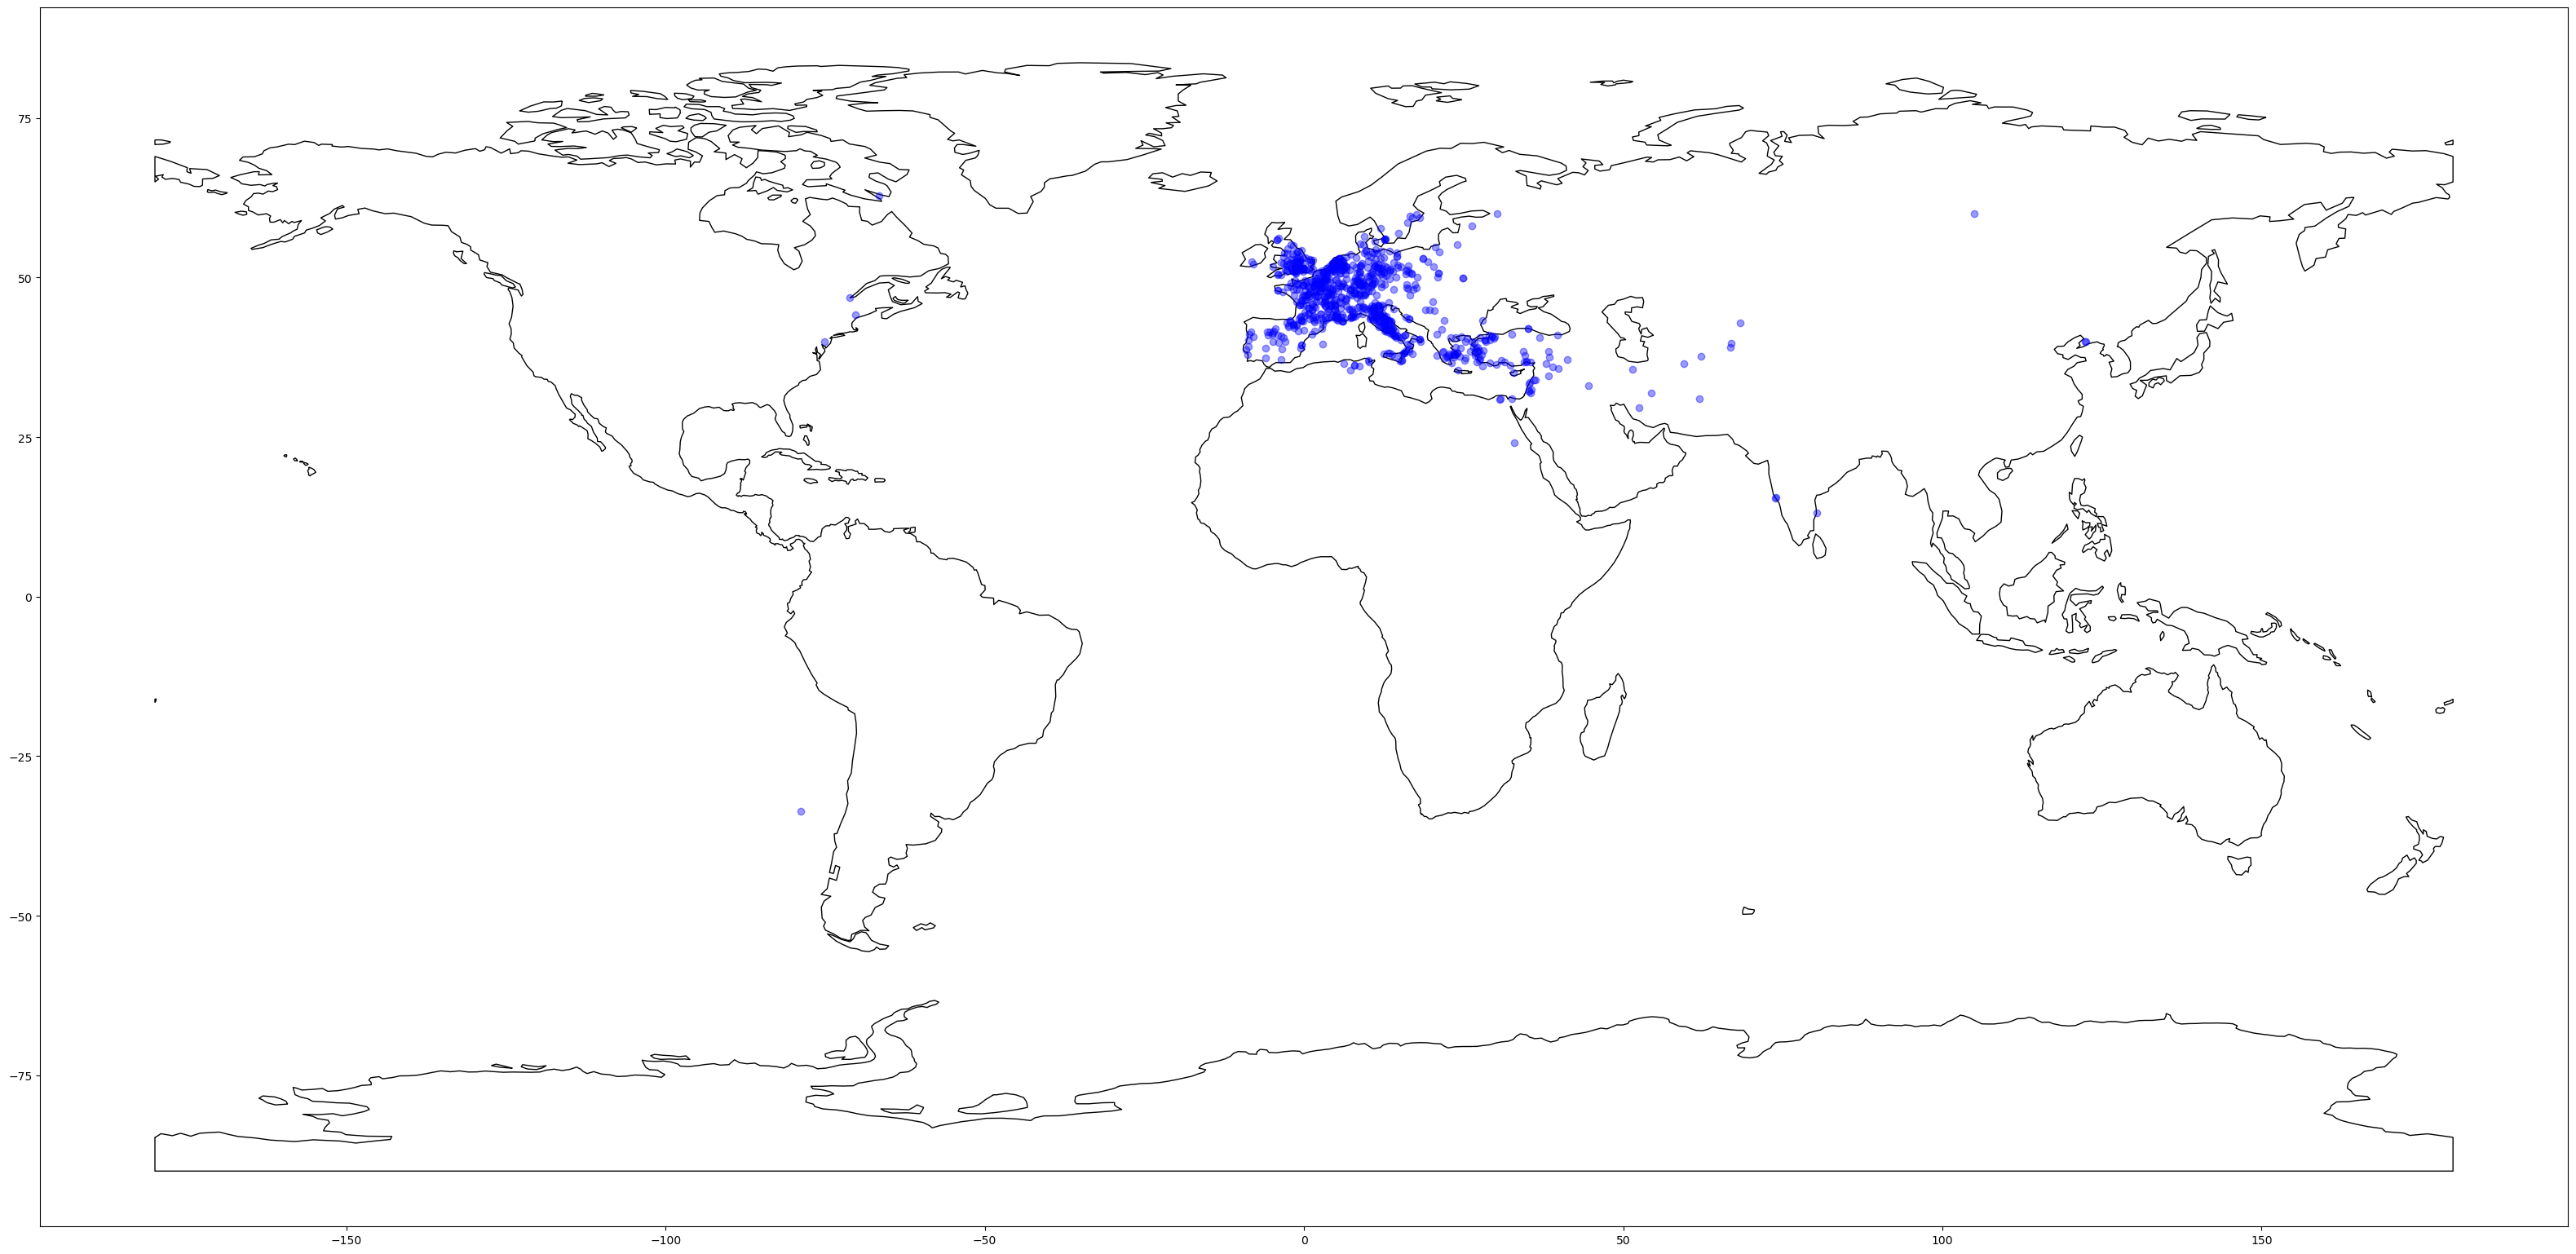

In [69]:
import matplotlib.pyplot as plt
ax = world.plot(
    color='white', edgecolor='black', figsize=(40, 60))
gdf.plot(ax=ax, color='blue', alpha=0.4)
plt.savefig('villes', bbox_inches='tight')
plt.show()

## Extraction de plus d'informations sur les êtres humains

In [70]:
def cree_requete_humain(cand):
    query = '''
    SELECT ?type ?dn ?dd ?libellé_fr ?desc_fr ?libellé_en ?desc_en ?ln ?ld ?occupations
    WHERE 
    {{
        OPTIONAL {{
            wd:{0}  wdt:P31 ?type .
        }}
        OPTIONAL {{
            wd:{0} rdfs:label ?libellé_fr filter (lang(?libellé_fr) = "fr") .
        }}
        OPTIONAL {{
            wd:{0} rdfs:label ?libellé_en filter (lang(?libellé_en) = "en") .
        }}
        OPTIONAL {{
            wd:{0} schema:description ?desc_fr filter (lang(?desc_fr) = "fr") .
        }}
        OPTIONAL {{
            wd:{0} schema:description ?desc_en filter (lang(?desc_en) = "en") .
        }}
        OPTIONAL {{
            wd:{0} wdt:P569 ?dn .
        }}
        OPTIONAL {{
            wd:{0} wdt:P570 ?dd .
        }}
        OPTIONAL {{
            wd:{0}  wdt:P19 ?ln .
        }}
        OPTIONAL {{
            wd:{0}  wdt:P20 ?ld .
        }}
        OPTIONAL {{
            wd:{0}  p:P106 ?occupation .
            ?occupation ps:P106 ?occupations .
        }}
    
    }}'''.format(cand)
    return query

In [71]:
a = cree_requete_humain('Q14279')

In [72]:
b = applique_requete(a, prefixes, headers)
b

[{'occupations': {'type': 'uri',
   'value': 'http://www.wikidata.org/entity/Q155647'},
  'desc_en': {'xml:lang': 'en',
   'type': 'literal',
   'value': 'Italian/French mathematician, astronomer, engineer, and astrologer (*1625 – †1712)'},
  'desc_fr': {'xml:lang': 'fr',
   'type': 'literal',
   'value': 'astronome et ingénieur, naturalisé français'},
  'libellé_en': {'xml:lang': 'en',
   'type': 'literal',
   'value': 'Giovanni Domenico Cassini'},
  'libellé_fr': {'xml:lang': 'fr',
   'type': 'literal',
   'value': 'Jean-Dominique Cassini'},
  'type': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q5'},
  'dn': {'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime',
   'type': 'literal',
   'value': '1625-06-08T00:00:00Z'},
  'dd': {'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime',
   'type': 'literal',
   'value': '1712-09-14T00:00:00Z'},
  'ln': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q269476'},
  'ld': {'type': 'uri', 'value': 'http://www.wikida

In [73]:
condense_dict(b[1])

{'occupations': 'http://www.wikidata.org/entity/Q81096',
 'desc_en': 'Italian/French mathematician, astronomer, engineer, and astrologer (*1625 – †1712)',
 'desc_fr': 'astronome et ingénieur, naturalisé français',
 'libellé_en': 'Giovanni Domenico Cassini',
 'libellé_fr': 'Jean-Dominique Cassini',
 'type': 'http://www.wikidata.org/entity/Q5',
 'dn': '1625-06-08T00:00:00Z',
 'dd': '1712-09-14T00:00:00Z',
 'ln': 'http://www.wikidata.org/entity/Q269476',
 'ld': 'http://www.wikidata.org/entity/Q90'}

In [74]:
lieux_humains[:10]

[['Q426025',
  ['Q460215',
   'Q76508',
   'Q209579',
   'Q451995',
   'Q444189',
   'Q312670',
   'Q520508',
   'Q312636',
   'Q356145',
   'Q355755',
   'Q461459',
   'Q451989',
   'Q373236',
   'Q451998',
   'Q318091',
   'Q451408']],
 ['Q1258998', ['Q43107']],
 ['Q13362', ['Q448191', 'Q196472', 'Q542039', 'Q1364155']],
 ['Q2832670', ['Q1429', 'Q313398']],
 ['Q271085', ['Q1771493']],
 ['Q234274', ['Q15630964']],
 ['Q210098', ['Q1088345']],
 ['Q326917', ['Q296367', 'Q311189']],
 ['Q740144', ['Q3047696']],
 ['Q3172', ['Q107278']]]

In [75]:
len(lieux_humains), sum(map(lambda x: len(x[1]), lieux_humains))

(829, 1716)

In [76]:
details_lieux_humains = []
for lieu_humains in tqdm(lieux_humains):
    while True:
        dicos_humains = {}
        temp_lieu_humains = []
        for humain in lieu_humains[1]:
            time.sleep(2)
            qt = cree_requete_humain(humain)
            dic_l = applique_requete(qt, prefixes, headers)
            if dic_l == ['échec']:
                break
            dicos_humains[humain] = fusionne_dicts_wd(dic_l)
        if dic_l != ['échec']:
            break
    details_lieux_humains += [(lieu_humains[0], dicos_humains)]

100%|██████████| 829/829 [1:09:25<00:00,  5.02s/it]


In [77]:
lieux_humains[:5]

[['Q426025',
  ['Q460215',
   'Q76508',
   'Q209579',
   'Q451995',
   'Q444189',
   'Q312670',
   'Q520508',
   'Q312636',
   'Q356145',
   'Q355755',
   'Q461459',
   'Q451989',
   'Q373236',
   'Q451998',
   'Q318091',
   'Q451408']],
 ['Q1258998', ['Q43107']],
 ['Q13362', ['Q448191', 'Q196472', 'Q542039', 'Q1364155']],
 ['Q2832670', ['Q1429', 'Q313398']],
 ['Q271085', ['Q1771493']]]

In [78]:
details_lieux_humains[:7]

[('Q426025',
  {'Q460215': {'occupations': ['Q2478141'],
    'desc_en': ['King of Jerusalem'],
    'desc_fr': ['duc de Savoie, roi titulaire de Jérusalem et de Chypre'],
    'libellé_en': ['Charles I, Duke of Savoy'],
    'libellé_fr': ['Charles Ier de Savoie'],
    'type': ['Q5'],
    'dn': ['1468-04-07T00:00:00Z'],
    'dd': ['1490-03-22T00:00:00Z'],
    'ln': ['Q9182'],
    'ld': ['Q9573']},
   'Q76508': {'occupations': ['Q82955', 'Q47064'],
    'desc_en': ['Duke of Savoy from 1553 to 1580'],
    'desc_fr': ['duc de Savoie'],
    'libellé_en': ['Emanuele Filiberto I, Duke of Savoy'],
    'libellé_fr': ['Emmanuel-Philibert de Savoie'],
    'type': ['Q5'],
    'dn': ['1528-07-18T00:00:00Z'],
    'dd': ['1580-09-09T00:00:00Z'],
    'ln': ['Q165090'],
    'ld': ['Q495']},
   'Q209579': {'occupations': ['Q82955'],
    'desc_en': ['Duke of Savoy and King of Sardinia (1675-1732)'],
    'desc_fr': ['roi de Sicile et Sardaigne'],
    'libellé_en': ['Victor Amadeus II of Savoy'],
    'libellé

In [79]:
lieux_humains[2]

['Q13362', ['Q448191', 'Q196472', 'Q542039', 'Q1364155']]

In [80]:
details_lieux_humains[1]

('Q1258998',
 {'Q43107': {'occupations': ['Q116', 'Q82955'],
   'desc_en': ['Augustus of the Eastern Roman Empire (244-311)'],
   'desc_fr': ['empereur romain de 284 à 305'],
   'libellé_en': ['Diocletian'],
   'libellé_fr': ['Dioclétien'],
   'type': ['Q5'],
   'dn': ['0240-01-01T00:00:00Z'],
   'dd': ['0316-12-04T00:00:00Z'],
   'ln': ['Q252273'],
   'ld': ['Q1258998']}})

In [81]:
details_lieux_humains[2]

('Q13362',
 {'Q448191': {'occupations': ['Q49757', 'Q36180', 'Q24387326'],
   'desc_en': ['Italian poet'],
   'desc_fr': ['humaniste italien'],
   'libellé_en': ['Giglio Gregorio Giraldi'],
   'libellé_fr': ['Lilio Gregorio Giraldi'],
   'type': ['Q5'],
   'dn': ['1479-01-01T00:00:00Z', '1479-06-22T00:00:00Z'],
   'dd': ['1552-02-01T00:00:00Z'],
   'ln': ['Q13362'],
   'ld': ['Q13362']},
  'Q196472': {'occupations': ['Q1234713',
    'Q1734662',
    'Q36180',
    'Q4964182',
    'Q11063',
    'Q17276298',
    'Q1622272'],
   'desc_en': ['16th century Italian theologian and astronomer'],
   'desc_fr': ['astronome et héologien italien'],
   'libellé_en': ['Giovanni Battista Riccioli'],
   'libellé_fr': ['Giovanni Battista Riccioli'],
   'type': ['Q5'],
   'dn': ['1598-04-17T00:00:00Z'],
   'dd': ['1671-06-25T00:00:00Z'],
   'ln': ['Q13362'],
   'ld': ['Q1891']},
  'Q542039': {'occupations': ['Q214917', 'Q36180', 'Q193391', 'Q49757'],
   'desc_en': ['Italian poet'],
   'desc_fr': ['poète i

In [82]:
len(details_lieux_humains[2][1].keys())

4

In [83]:
len(details_lieux_humains), sum(
    map(lambda x: len(x[1].keys()), details_lieux_humains))

(829, 1716)

In [84]:
with open('lieux_humains_details.json', 'w') as f:
    json.dump(details_lieux_humains, f)